# Setup Environment

In [1]:
import os
import sys
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [2]:
def init_spark():
    return SparkSession \
        .builder \
        .master("local[*]") \
        .appName("Chess Predict") \
        .config("spark.some.config.option", "some-value") \
        .getOrCreate()

spark = init_spark()

In [3]:
seed = 42

# Load Dataset

In [4]:
df_train = spark.read.parquet('data/train.parquet')
df_test = spark.read.parquet('data/test.parquet', header=True, inferSchema=True)

# Classification Problem
 In a new match between two players, who is most likely to win?

## Feature Selection

In [5]:
features = 'rated', 'turns', 'match_status', 'clock', 'increment', 'white_rating', 'black_rating', 'open_cat', 'opening_ply', 'moves_vec'
target = 'winner'
inputColumns = features + (target,)
inputColumns

('rated',
 'turns',
 'match_status',
 'clock',
 'increment',
 'white_rating',
 'black_rating',
 'open_cat',
 'opening_ply',
 'moves_vec',
 'winner')

In [6]:
training_assembler = VectorAssembler(handleInvalid='error', inputCols=features, outputCol='features')
test_assembler = VectorAssembler(handleInvalid='error', inputCols=features, outputCol='features')

In [7]:
clf_train_df = training_assembler.transform(df_train.select(*inputColumns)).select('features', target)
clf_test_df = test_assembler.transform(df_test.select(*inputColumns)).select('features', target)

## Model Selection

In [8]:
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from cf_matrix import make_confusion_matrix

In [9]:
skipGridSearch = True

### *Decision Tree* for Classification

In [10]:
dt = DecisionTreeClassifier(labelCol=target, featuresCol="features", seed=seed)

dtParamGrid = (ParamGridBuilder()
               .addGrid(dt.maxDepth, list(range(2, 8)))
               .addGrid(dt.maxBins, [4, 8, 16, 32, 64])
               .addGrid(dt.minInstancesPerNode, list(range(1, 4)))
               .addGrid(dt.impurity, ['gini', 'entropy'])
               .build())

dtEvaluator = MulticlassClassificationEvaluator(labelCol=target, metricName='f1')

From [Spark Docs](https://spark.apache.org/docs/latest/mllib-decision-tree.html#tunable-parameters)
- `maxDepth`: Maximum depth of a tree. Deeper trees are more expressive (potentially allowing higher accuracy), but they are also more costly to train and are more likely to overfit.
- `minInstancesPerNode`: For a node to be split further, each of its children must receive at least this number of training instances. This is commonly used with RandomForest since those are often trained deeper than individual trees.
- `maxBins`: Number of bins used when discretizing continuous features.
- `impurity`: Measure of the homogeneity of the labels at the node. (Choice of `gini` and `entropy` for classification)

#### Hyperparameter Tuning (Grid Search)  20-30 minutes

In [11]:
if not skipGridSearch:
    dtCv = CrossValidator(estimator = dt,
                          estimatorParamMaps = dtParamGrid,
                          evaluator = dtEvaluator,
                          numFolds = 5)

    dtCvModel = dtCv.fit(clf_train_df)

    # Best Parameters found
    bestParamMap = dtCvModel.bestModel.extractParamMap()
    print( ','.join([''.join((param.name, '=', repr(value))) for param, value in bestParamMap.items()]) )

#### Model Train

In [12]:
# Use Best Parameters to initialize and train a separate classifier model
dtBest = DecisionTreeClassifier(cacheNodeIds=False,checkpointInterval=10,featuresCol='features',impurity='gini',labelCol='winner',leafCol='',maxBins=8,maxDepth=6,maxMemoryInMB=256,minInfoGain=0.0,minInstancesPerNode=1,minWeightFractionPerNode=0.0,predictionCol='prediction',probabilityCol='probability',rawPredictionCol='rawPrediction',seed=42)
# assert dtBest.extractParamMap() == bestParamMap, 'Check if the input parameters are the best found. '
bestModel = dtBest.fit(clf_train_df)

#### Model Evaluation

In [13]:
trainPredictionAndLabels = bestModel.transform(clf_train_df).select('prediction', target)
testPredictionAndLabels = bestModel.transform(clf_test_df).select('prediction', target)
print('train f1 score', dtEvaluator.evaluate(trainPredictionAndLabels))
print('test f1 score', dtEvaluator.evaluate(testPredictionAndLabels))

train f1 score 0.706133786987661
test f1 score 0.6720110224218644


In [14]:
confusionMatrix = MulticlassMetrics(testPredictionAndLabels.rdd.map(tuple)).confusionMatrix().toArray()

C:\tools\miniconda3\envs\bigdata\lib\site-packages\pyspark\sql\context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


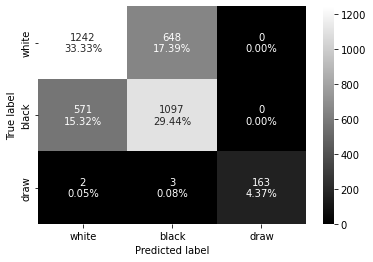

In [15]:
categories = ['white', 'black', 'draw']
make_confusion_matrix(confusionMatrix, categories=categories, sum_stats=False, cmap='gray')

Because the classes are imbalanced and that we don't favor one class over the other, we adopted the F1 score as the main metric to evaluate our model. Given that there are 3 output classes, this result is acceptable for a simple decision tree classifier. For better performance, we could use Ensembling methods such as Random Forest.

### *Logistic Regression*

In [16]:
lr = LogisticRegression(labelCol=target, featuresCol="features")

lrParamGrid = (ParamGridBuilder()
               .addGrid(lr.regParam, [0.01, 0.1, 0.2, 0.8, 2.0])
               .addGrid(lr.elasticNetParam, [0.0, 0.1, 0.2, 0.3, 0.4])
               .addGrid(lr.fitIntercept, [True, False])
               .addGrid(lr.maxIter, [10, 30, 50, 70, 100])
               .build())

lrEvaluator = MulticlassClassificationEvaluator(labelCol=target, metricName='f1')

From [Medium Article by Dhiraj Rai](https://dhiraj-p-rai.medium.com/logistic-regression-in-spark-ml-8a95b5f5434c)
- `regParam` the regularization parameter (>= 0). (default: 0.0)
- `elasticNetParam` the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
- `fitIntercept` whether to fit an intercept term. (default: True)
- `maxIter` maximum iteration number.
- `standardization` whether to standardize the training features before fitting the model. The coefficients of models will always be returned on the original scale, so it will be transparent for users. (default: True)

#### Hyperparameter Tuning (Grid Search) ~50 minutes

In [17]:
if not skipGridSearch:
    lrCv = CrossValidator(estimator = lr,
                          estimatorParamMaps = lrParamGrid,
                          evaluator = lrEvaluator,
                          numFolds = 5)

    lrCvModel = lrCv.fit(clf_train_df)

    # Best Parameters found
    bestParamMap = lrCvModel.bestModel.extractParamMap()
    print( ','.join([''.join((param.name, '=', repr(value))) for param, value in bestParamMap.items()]) )

#### Model Train

In [18]:
lrBest = LogisticRegression(aggregationDepth=2,elasticNetParam=0.2,family='auto',featuresCol='features',fitIntercept=False,labelCol='winner',maxBlockSizeInMB=0.0,maxIter=100,predictionCol='prediction',probabilityCol='probability',rawPredictionCol='rawPrediction',regParam=0.01,standardization=True,threshold=0.5,tol=1e-06)
# assert lrBest.extractParamMap() == bestParamMap, 'Check if the input parameters are the best found. '
bestModel = lrBest.fit(clf_train_df)

#### Model Evaluation

In [19]:
trainPredictionAndLabels = bestModel.transform(clf_train_df).select('prediction', target)
testPredictionAndLabels = bestModel.transform(clf_test_df).select('prediction', target)
print('train f1 score', lrEvaluator.evaluate(trainPredictionAndLabels))
print('test f1 score', lrEvaluator.evaluate(testPredictionAndLabels))

train f1 score 0.7636212881018776
test f1 score 0.7470659930946674


In [20]:
confusionMatrix = MulticlassMetrics(testPredictionAndLabels.rdd.map(tuple)).confusionMatrix().toArray()

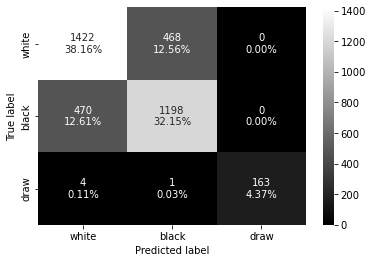

In [21]:
categories = ['white', 'black', 'draw']
make_confusion_matrix(confusionMatrix, categories=categories, sum_stats=False, cmap='gray')

The LogisticRegression performs significantly better than the DecisionTreeRegressor.

# Regression Problem
 Can a player's rating be determined from a single match record with another player?

## Feature Selection

In [22]:
features = 'rated', 'turns', 'match_status', 'clock', 'increment', 'open_cat', 'opening_ply', 'moves_vec', 'winner', #'white_rating',
target = 'black_rating'
inputColumns = features + (target,)
inputColumns

('rated',
 'turns',
 'match_status',
 'clock',
 'increment',
 'open_cat',
 'opening_ply',
 'moves_vec',
 'winner',
 'black_rating')

In [23]:
training_assembler = VectorAssembler(handleInvalid='error', inputCols=features, outputCol='features')
test_assembler = VectorAssembler(handleInvalid='error', inputCols=features, outputCol='features')

In [24]:
reg_train_df = training_assembler.transform(df_train.select(*inputColumns)).select('features', target)
reg_test_df = test_assembler.transform(df_test.select(*inputColumns)).select('features', target)

## Model Selection

In [25]:
from pyspark.ml.regression import DecisionTreeRegressor, LinearRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
import seaborn as sns
import matplotlib.pyplot as plt

### *Decision Tree* for Regression

In [26]:
dt = DecisionTreeRegressor(labelCol=target, featuresCol="features", seed=seed)

dtParamGrid = (ParamGridBuilder()
               .addGrid(dt.maxDepth, list(range(2, 8)))
               .addGrid(dt.maxBins, [4, 8, 16, 32, 64])
               .addGrid(dt.minInstancesPerNode, list(range(1, 4)))
               .build())

dtEvaluator = RegressionEvaluator(labelCol=target, metricName='rmse')

From [Spark Docs](https://spark.apache.org/docs/latest/mllib-decision-tree.html#tunable-parameters)
- `maxDepth`: Maximum depth of a tree. Deeper trees are more expressive (potentially allowing higher accuracy), but they are also more costly to train and are more likely to overfit.
- `minInstancesPerNode`: For a node to be split further, each of its children must receive at least this number of training instances. This is commonly used with RandomForest since those are often trained deeper than individual trees.
- `maxBins`: Number of bins used when discretizing continuous features.
- `impurity`: Impurity measure used to choose between candidate splits. (Only `variance` for regression)

#### Hyperparameter Tuning (Grid Search) ~18 min

In [27]:
if not skipGridSearch:
    dtCv = CrossValidator(estimator = dt,
                          estimatorParamMaps = dtParamGrid,
                          evaluator = dtEvaluator,
                          numFolds = 5)

    dtCvModel = dtCv.fit(reg_train_df)

    # Best Parameters found
    bestParamMap = dtCvModel.bestModel.extractParamMap()
    print( ','.join([''.join((param.name, '=', repr(value))) for param, value in bestParamMap.items()]) )

#### Model Train

In [28]:
# Use Best Parameters to initialize and train a separate regressor model
dtBest = DecisionTreeRegressor(cacheNodeIds=False,checkpointInterval=10,featuresCol='features',impurity='variance',labelCol='black_rating',leafCol='',maxBins=8,maxDepth=6,maxMemoryInMB=256,minInfoGain=0.0,minInstancesPerNode=3,minWeightFractionPerNode=0.0,predictionCol='prediction',seed=42)
# assert dtBest.extractParamMap() == bestParamMap, 'Check if the input parameters are the best found. '
bestModel = dtBest.fit(reg_train_df)

#### Model Evaluation

In [29]:
trainPredAndLabels = bestModel.transform(reg_train_df).select('prediction', target)
testPredAndLabels = bestModel.transform(reg_test_df).select('prediction', target)
print('train rmse', dtEvaluator.evaluate(trainPredAndLabels))
print('test rmse', dtEvaluator.evaluate(testPredAndLabels))

train rmse 259.3537297282463
test rmse 275.8599898782995


C:\tools\miniconda3\envs\bigdata\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\tools\miniconda3\envs\bigdata\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


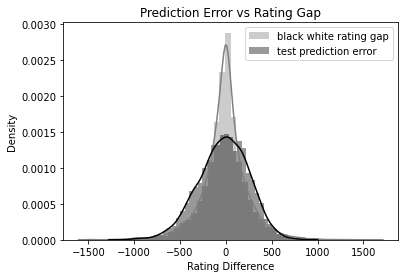

In [30]:
sns.distplot(df_train.selectExpr('black_rating - white_rating').toPandas(), label='black white rating gap', color='gray')
sns.distplot(testPredAndLabels.selectExpr(f'prediction - {target}').toPandas(), label='test prediction error', color='k')
plt.title('Prediction Error vs Rating Gap')
plt.xlabel('Rating Difference')
plt.legend()
plt.show()

The RMSE score is very close to the standard deviation of the difference between `black_rating` and `white_rating`. If the model is given the `white_rating` feature, the RMSE would see a decrease of about 40, further improving the model prediction.

### *Linear Regression*

In [31]:
lr = LinearRegression(labelCol=target, featuresCol="features")

lrParamGrid = (ParamGridBuilder()
               .addGrid(lr.regParam, [0.01, 0.1, 0.2, 0.8, 2.0])
               .addGrid(lr.elasticNetParam, [0.0, 0.1, 0.2, 0.3, 0.4])
               .addGrid(lr.fitIntercept, [True, False])
               .addGrid(lr.maxIter, [10, 30, 50, 70, 100])
               .addGrid(lr.solver, ['auto', 'normal', 'l-bfgs'])
               .build())

lrEvaluator = RegressionEvaluator(labelCol=target, metricName='rmse')

From [Medium Article by Dhiraj Rai](https://dhiraj-p-rai.medium.com/logistic-regression-in-spark-ml-8a95b5f5434c)
- `regParam` the regularization parameter (>= 0). (default: 0.0)
- `elasticNetParam` the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
- `fitIntercept` whether to fit an intercept term. (default: True)
- `maxIter` maximum iteration number.
- `standardization` whether to standardize the training features before fitting the model. The coefficients of models will always be returned on the original scale, so it will be transparent for users. (default: True)

#### Hyperparameter Tuning (Grid Search)

In [32]:
if not skipGridSearch:
    lrCv = CrossValidator(estimator = lr,
                          estimatorParamMaps = lrParamGrid,
                          evaluator = lrEvaluator,
                          numFolds = 5)

    lrCvModel = lrCv.fit(reg_train_df)

    # Best Parameters found
    bestParamMap = lrCvModel.bestModel.extractParamMap()
    print( ','.join([''.join((param.name, '=', repr(value))) for param, value in bestParamMap.items()]) )

#### Model Train

In [33]:
lrBest = LinearRegression(aggregationDepth=2,elasticNetParam=0.0,epsilon=1.35,featuresCol='features',fitIntercept=True,labelCol='black_rating',loss='squaredError',maxBlockSizeInMB=0.0,maxIter=30,predictionCol='prediction',regParam=0.1,solver='auto',standardization=True,tol=1e-06)
# assert lrBest.extractParamMap() == bestParamMap, 'Check if the input parameters are the best found. '
bestModel = lrBest.fit(reg_train_df)

#### Model Evaluation

In [34]:
trainPredAndLabels = bestModel.transform(reg_train_df).select('prediction', target)
testPredAndLabels = bestModel.transform(reg_test_df).select('prediction', target)
print('train rmse', lrEvaluator.evaluate(trainPredAndLabels))
print('test rmse', lrEvaluator.evaluate(testPredAndLabels))

train rmse 250.66053890029065
test rmse 258.24699917173854


C:\tools\miniconda3\envs\bigdata\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\tools\miniconda3\envs\bigdata\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


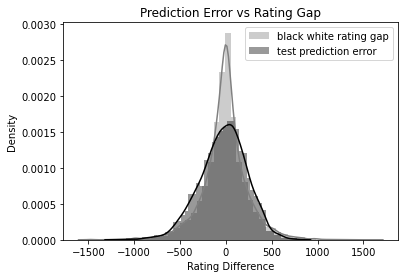

In [35]:
sns.distplot(df_train.selectExpr('black_rating - white_rating').toPandas(), label='black white rating gap', color='gray')
sns.distplot(testPredAndLabels.selectExpr(f'prediction - {target}').toPandas(), label='test prediction error', color='k')
plt.title('Prediction Error vs Rating Gap')
plt.xlabel('Rating Difference')
plt.legend()
plt.show()

Similarly to DecisionTreeRegressor, the RMSE score is very close to the standard deviation of the difference between `black_rating` and `white_rating`. It performs slightly better. If the model is given the `white_rating` feature, the RMSE would see a decrease of about 40, further improving the model prediction.